## Problem Statement: Predict the pay-range a given employee would belong to, based on the analysis of different attributes of other employees & their respective pay-range.

#### *The dataset is sourced from http://openbook.sfgov.org, which is part of the Government of San Francisco city's initiative in providing open & easily accessible data related to performance & spending across different departments of San Francisco City government. Salary range is the range of pay established by employers to pay to employees performing a particular job or function. Salary range generally has a minimum pay rate, a maximum pay rate, and a series of mid-range opportunities for pay increases.*

#### *The salary range is determined by market pay rates, organization, department, union, type and domain of jobs, established through market pay studies, for people doing similar work in similar industries in the same region of the country. Pay rates and salary ranges are also set up by individual employers and recognize the level of education, knowledge, skill, and experience needed to perform each job. Its a database of the salary and benefits paid to City employees since fiscal year 2013.*

#### *This data is summarized and presented on the Employee Compensation report hosted at http://openbook.sfgov.org*

#### *The different attributes which are assumed to influence an employee's pay-range & compensation, and features against which data was collected are given below -*

#### *1. Year Type -* Fiscal (July through June) or Calendar (January through December)
#### *2. Year -* An accounting period of 12 months. The City and County of San Francisco operates on a fiscal year that begins on July 1 and ends on June 30 the following year. The Fiscal Year ending June 30, 2012 is represented as FY 2011-2012.
#### *3. Organization Group Code -* Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police, Fire, Adult Probation, District Attorney, and Sheriff.
#### *4. Organization Group -* Org Group is a group of Departments. For example, the Public Protection Org Group includes departments such as the Police, Fire, Adult Probation, District Attorney, and Sheriff.
#### *5. Department Code -* Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
#### *6. Department -* Departments are the primary organizational unit used by the City and County of San Francisco. Examples include Recreation and Parks, Public Works, and the Police Department.
#### *7. Union Code -* Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
#### *8. Union -* Unions represent employees in collective bargaining agreements. A job belongs to one union, although some jobs are unrepresented (usually temporarily).
#### *9. Job Family Code -* Job Family combines similar Jobs into meaningful groups.
#### *10. Job Family -* Job Family combines similar Jobs into meaningful groups.
#### *11. Job Code -* Jobs are defined by the Human Resources classification unit. Examples include gardeners, police officers, and accountants.
#### *12. Job -* Jobs are defined by the Human Resources classification unit. Examples include gardeners, police officers, and accountants.
#### *13. Employee Identifier -* Each distinct number in the “Employee Identifier” column represents one employee. These identifying numbers are not meaningful but rather are randomly assigned for the purpose of building this dataset. The column does not appear on the Employee Compensation report hosted on openbook.sfgov.org, but that report does show one row for each employee. Employee ID has been included here to allow users to reconstruct the original report. Note that each employee’s identifier will change each time this dataset is updated, so comparisons by employee across multiple versions of the dataset are not possible.
#### *14. Overtime -* Amounts paid to City employees working in excess of 40 hours per week.
#### *15. Other Salaries -* Various irregular payments made to City employees including premium pay, incentive pay, or other one-time payments.
#### *16. Retirement -* City contributions to employee retirement plans.
#### *17. Health/Dental -* City-paid premiums to health and dental insurance plans covering City employees. To protect confidentiality as legally required, pro-rated citywide averages are presented in lieu of employee-specific health and dental benefits.
#### *18. Other Benefits -* Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment insurance premiums, and minor discretionary benefits not included in the above categories.
#### *19. Total Benefits -* The sum of all benefits paid to City employees.
#### *20. Class -* Class of Normal salaries paid to permanent or temporary City employees.

#### *The target/label comprises of the 3 pay-range:* 
#### *1. Low range salary*
#### *2. Mid range salary*
#### *3. High range salary*

In [1]:
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from scipy import stats

Using TensorFlow backend.


#### *The dataset is given in 2 sets: train & test, wherein the test set doesn't have the labels marked. Thus the train set has to be split for actual training & validation*

In [3]:
train=pd.read_csv('/Users/debajyotidas/Google Drive/PGP-AIML/Hackathon/train.csv')
test=pd.read_csv('/Users/debajyotidas/Google Drive/PGP-AIML/Hackathon/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149087 entries, 0 to 149086
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       149087 non-null  int64  
 1   Year Type                149087 non-null  object 
 2   Year                     149087 non-null  int64  
 3   Organization Group Code  149087 non-null  int64  
 4   Organization Group       149087 non-null  object 
 5   Department Code          149087 non-null  object 
 6   Department               149087 non-null  object 
 7   Union Code               149087 non-null  int64  
 8   Union                    149087 non-null  object 
 9   Job Family Code          149087 non-null  object 
 10  Job Family               149087 non-null  object 
 11  Job Code                 149087 non-null  object 
 12  Job                      149087 non-null  object 
 13  Employee Identifier      149087 non-null  int64  
 14  Over

In [89]:
train['Class'].value_counts()

3    50811
2    49604
1    48672
Name: Class, dtype: int64

#### *There are altogether 19 features & 1 label distributed across approx. 150 thousand datapoints. Of these 19 features, some are string/object type while the others are numerical (integer or floating point). Most ML algorithms work well with numerical data, and non-numerical categorical data usually needs to be ENCODED into some numerical form or the other.* 
#### *Some of these features may be redundant, while others may be not so important. We will inspect them individually*
#### *Lastly the target variable comprises of 3 classes and the classes seem to be slightly imbalanced. We can try introducing synthetic methods like SMOTE & RandomUnderSampler to handle this imbalance, so that the model is capable of classifying all the 3 classes equally well*

In [6]:
train.head()

,ID,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,...,Job Code,Job,Employee Identifier,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,9248,Fiscal,2017,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2905,Senior Eligibility Worker,41351,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,44541,Fiscal,2014,6,General Administration & Finance,ASR,ASR Assessor / Recorder,21,"Prof & Tech Engineers - Miscellaneous, Local 21",4200,...,4222,Sr Personal Property Auditor,41792,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,47031,Fiscal,2014,3,Human Welfare & Neighborhood Development,DSS,HSA Human Services Agency,535,"SEIU - Human Services, Local 1021",2900,...,2910,Social Worker,9357,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,139416,Fiscal,2014,1,Public Protection,FIR,FIR Fire Department,798,"Firefighters - Miscellaneous, Local 798",H000,...,H002,Firefighter,28022,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,123780,Fiscal,2013,2,"Public Works, Transportation & Commerce",MTA,MTA Municipal Transprtn Agncy,790,"SEIU - Miscellaneous, Local 1021",1600,...,1224,Pr Payroll & Personnel Clerk,51052,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


In [4]:
label_encoder = LabelEncoder()
lbl_binarizer1 = LabelBinarizer()
lbl_binarizer2 = LabelBinarizer()
lbl_binarizer3 = LabelBinarizer()
train['Year']= label_encoder.fit_transform(train['Year'])
train['Department Code']= lbl_binarizer1.fit_transform(train['Department Code'])
train['Job Family Code']= lbl_binarizer2.fit_transform(train['Job Family Code'])
train['Job Code']= lbl_binarizer3.fit_transform(train['Job Code'])

In [5]:
test['Year']= label_encoder.fit_transform(test['Year'])
test['Department Code']= lbl_binarizer1.transform(test['Department Code'])
test['Job Family Code']= lbl_binarizer2.transform(test['Job Family Code'])
test['Job Code']= lbl_binarizer3.transform(test['Job Code'])

#### *We first fit the encoder objects on the training data & then transform the same. The same object is then also used to transform the test data. As in this case we are using the train data for both training & validation, it would have been necessary to perform any transformative functions like scaling on the training data after splitting the same for training & testing. Fortunately such activity has not been needed due to our choice of ML algorithm, Tree based Classifiers - Random Forest & XGBClassifier, followed by stacking the 2*

#### *LabelBinarizer helps in generating one-hot encoded data from multi-class object/string data. LabelEncoder helps in generating ordered numeric feature by encoding ordinal numeric/object data*

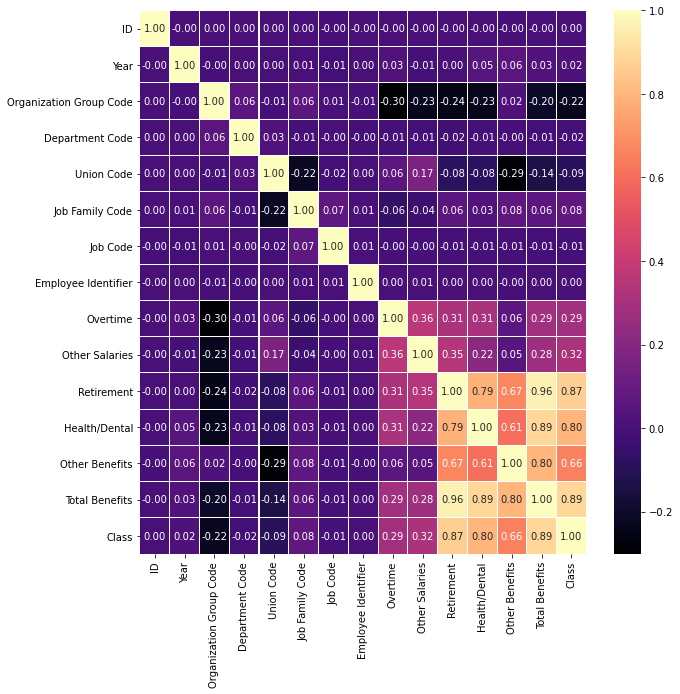

In [199]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(train.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 

#### *From the above description we can see that the columns 'Organization Group','Department','Union','Job Family','Job','Employee Identifier','Year Type' are either redundant or are containing not important information. The same information as 'Organization Group','Department','Union','Job Family', and 'Job' is contained in 'Organization Group Code','Department Code','Union Code','Job Family Code',and 'Job Code' respectively. This data being available in numeric format is more suitable for analysis.*

#### *Additionally, information like 'Year Type','ID' and 'Employee Identifier' are either not unique for different employees or there is no visible strong correlation between the same & the target variable 'Class'. Thus we can drop them also.*

In [6]:
train.drop(columns=['ID','Organization Group','Department','Union',
                    'Job Family','Job','Employee Identifier','Year Type'],axis=1,inplace=True)

test.drop(columns=['ID','Organization Group','Department','Union',
                   'Job Family','Job','Employee Identifier', 'Year Type'],axis=1,inplace=True)

In [201]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149087 entries, 0 to 149086
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Year                     149087 non-null  int64  
 1   Organization Group Code  149087 non-null  int64  
 2   Department Code          149087 non-null  int64  
 3   Union Code               149087 non-null  int64  
 4   Job Family Code          149087 non-null  int64  
 5   Job Code                 149087 non-null  int64  
 6   Overtime                 149087 non-null  float64
 7   Other Salaries           149087 non-null  float64
 8   Retirement               149087 non-null  float64
 9   Health/Dental            149087 non-null  float64
 10  Other Benefits           149087 non-null  float64
 11  Total Benefits           149087 non-null  float64
 12  Class                    149087 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 14.8 MB


In [202]:
train.head()

,Year,Organization Group Code,Department Code,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Retirement,Health/Dental,Other Benefits,Total Benefits,Class
0,4,3,0,535,0,0,0.00,240.00,11896.36,13765.55,5248.43,30910.34,2
1,1,6,0,21,0,0,0.00,400.00,15429.94,9337.37,5599.01,30366.32,2
2,1,3,0,535,0,0,0.00,1080.00,9682.00,8848.03,3463.92,21993.95,2
3,1,1,0,798,0,0,25730.46,18414.18,24222.26,13911.13,2416.58,40549.97,3
4,0,2,0,790,0,0,1138.28,2148.11,15437.62,12828.15,7246.54,35512.31,3


No handles with labels found to put in legend.


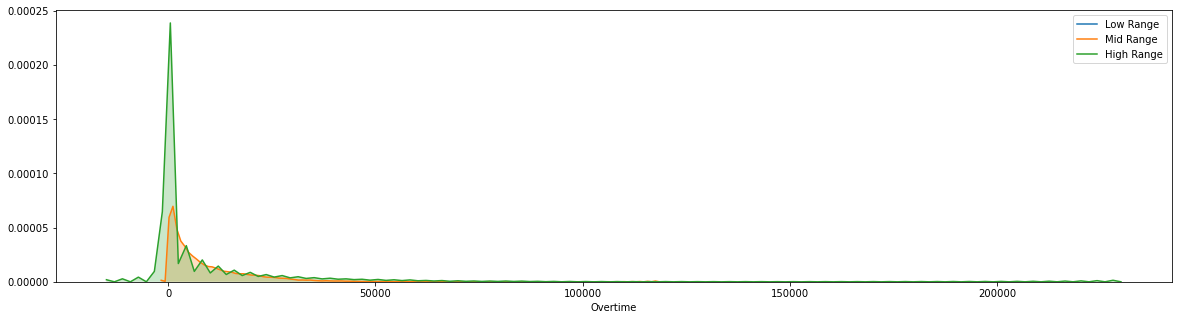

In [15]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Overtime')
sns.kdeplot(train[train['Class']==1]['Overtime'],label='Low Range',shade=True)
sns.kdeplot(train[train['Class']==2]['Overtime'],label='Mid Range',shade=True)
sns.kdeplot(train[train['Class']==3]['Overtime'],label='High Range',shade=True)

No handles with labels found to put in legend.


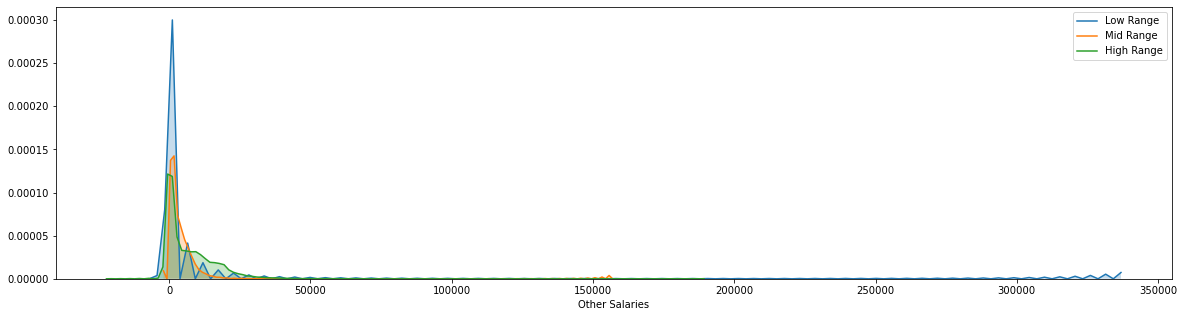

In [16]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Other Salaries')
sns.kdeplot(train[train['Class']==1]['Other Salaries'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Other Salaries'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Other Salaries'],label='High Range', shade=True)

No handles with labels found to put in legend.


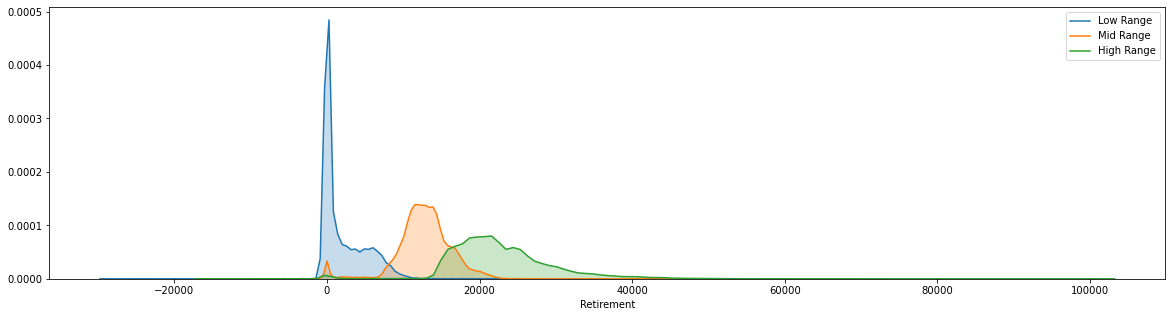

In [17]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Retirement')
sns.kdeplot(train[train['Class']==1]['Retirement'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Retirement'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Retirement'],label='High Range', shade=True)

No handles with labels found to put in legend.


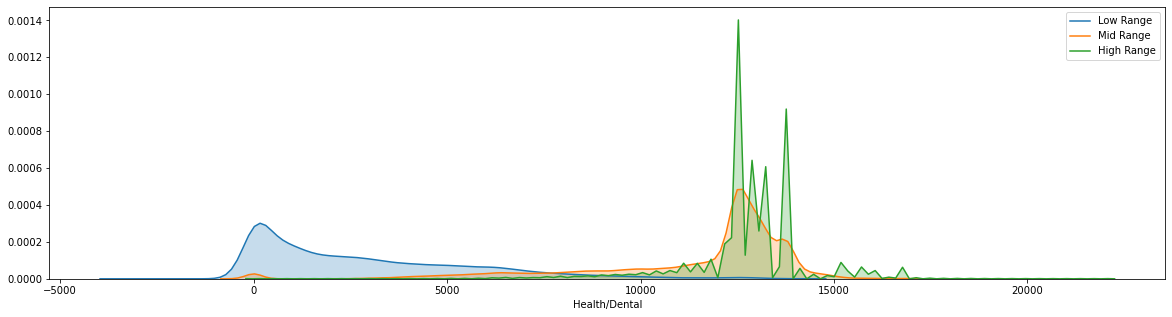

In [18]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Health/Dental')
sns.kdeplot(train[train['Class']==1]['Health/Dental'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Health/Dental'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Health/Dental'],label='High Range', shade=True)

No handles with labels found to put in legend.


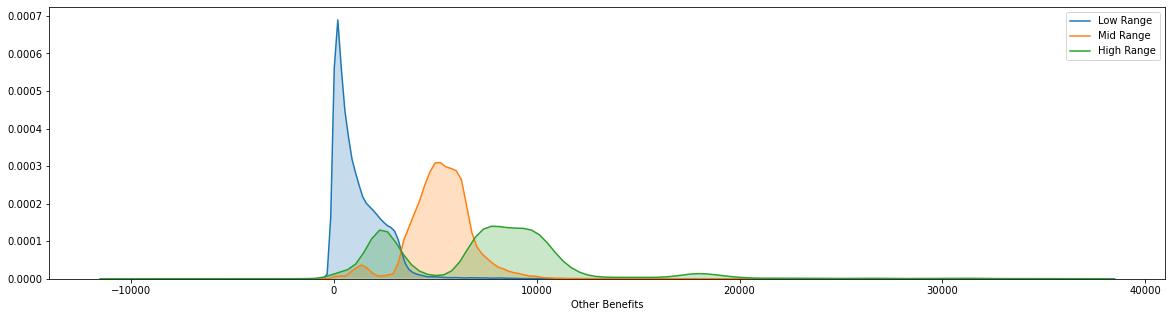

In [19]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Other Benefits')
sns.kdeplot(train[train['Class']==1]['Other Benefits'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Other Benefits'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Other Benefits'],label='High Range', shade=True)

No handles with labels found to put in legend.


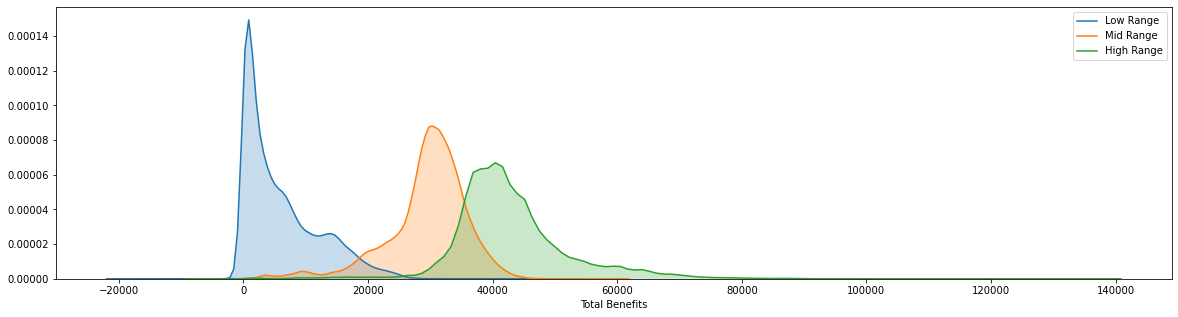

In [20]:
plt.figure(figsize=(20,5))
plt.legend()
plt.xlabel('Total Benefits')
sns.kdeplot(train[train['Class']==1]['Total Benefits'],label='Low Range', shade=True)
sns.kdeplot(train[train['Class']==2]['Total Benefits'],label='Mid Range', shade=True)
sns.kdeplot(train[train['Class']==3]['Total Benefits'],label='High Range', shade=True)

#### *It seems from the above EDA that Low Range employees receive mostly no Retirement, Other Salaries and Other Benefits. Thus oevrall amount of benefits received by Low Range earners is very less*

#### *In case of Mid Range earners, they seem to be the largest earners of Overtime. Their Other Salaries mostly seem to be zero, same as Low Range & High Range earners. Retirement benefits is less than High Range earners, but there is significant over-lap between the higher range of Retirement benefits of Mid Range earners & lower-range of Retirement benefits of High Range earners. Health/Dental benefits are identical with that of High Range earners while Other Benefits component is significantly higher for Mid Range earners, as compared to the other 2 class*

#### *High-Range earners mostly don't earn any Overtime or Other Salaries. As already seen, they earn slightly better Other Benefits & Retirals than Mid-Range earners, with whom they share similar Health/Dental benefits*

In [7]:
#Dropping the target column 'Class' from the train data & storing it into a new variable
y = train['Class']
train.drop('Class',axis=1,inplace=True)

#### *Splitting the train data into 2 sets for training & validation by a 70:30 split (test_size=0.3). Further this split will be done after ensuring that the features are distributed in the same proportions in the 2 datasets, i.e. if if the 3 classes were initially distributed in the main dataset in a 30:40:30 ratio, the same will be maintained in the x_train & x_val also. This is achieved by the 'stratify' command, although it may not provide useful in the current context as we will be employing Up-sampling & Down-sampling techniques.*
#### *The random_state ensures reproducability over multiple execution cycles*

In [8]:
x_train,x_val,y_train,y_val = train_test_split(train,y,test_size=0.3,random_state=42,stratify=y)

In [55]:
y_train.value_counts()

3    35567
2    34723
1    34070
Name: Class, dtype: int64

#### *As we can see from the above, there is some slight imbalance in the distribution of the 3 classes, with Mid-Range & Low-Range Salary earners being 97% & 95% respectively of the High-Range salary earners. This might impact our models ability to make correct predictions across all the different classes & thus we employ up-sampling & down-sampling techniques like SMOTE & RandomUnderSampler respectively so that all the 3 classes have equal number of data-points during training (here 35000).*
#### *The above transformation will be applicable only on the training data while the validation data will continue to remain untouched & represent the real dataset as closely as possible (ensured by our stratified train-test split)*

In [9]:
over = SMOTE(sampling_strategy={1:35000,2:35000},random_state=42)
under = RandomUnderSampler(sampling_strategy={3:35000})

In [10]:
#We are running the RandomForeClassifier with 
model = RandomForestClassifier(criterion='entropy',
                              oob_score=True,
                              random_state=42,
                              n_jobs=10)

In [11]:
#Building a pipeline of execution steps of Up-Sampling, Down-Sampling & Lastly Model fit and/or prediction
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)

In [15]:
start_time = timeit.default_timer()
pipeline.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',pipeline.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))

start_time = timeit.default_timer()
y_pred_test = model.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  0.9999329244921425

 Total Training Time: 26.54 seconds.

 Testing Accuracy is:  0.9856462539405728

 Total Testing Time: 0.43 seconds.


In [16]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

precision    recall  f1-score   support

           1       0.99      0.99      0.99     14602
           2       0.98      0.98      0.98     14881
           3       0.99      0.99      0.99     15244

    accuracy                           0.99     44727
   macro avg       0.99      0.99      0.99     44727
weighted avg       0.99      0.99      0.99     44727



In [18]:
#Running the aforesaid model on the entire dataset now in 10-fold Cross-Validation to verify average score of the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores=cross_val_score(model,train,y,scoring='accuracy',cv=cv,n_jobs=-1,verbose=1)
print('Average Score across 10-fold Cross-Validation over 3 iterations is: ',scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Average Score across 10-fold Cross-Validation over 3 iterations is:  0.9868421380439298
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.6min finished


#### *We can see that the RandomForest Classifier model has done quiet well with a 98.56% validation accuracy. However the model does seem to be over-fit with training accuracy being almost 100%. However the validation accuracy is quiet comparable & thus we have to withold our judgement on over-fitting for now.* 
#### *Similarly from the class-wise Confusion Matrix, we can see that the model has not been able to predict all the 3 different classes equally well, with there still being a bias towards classes 1 & 3.*
#### *When we run the model over the entire dataset, across 10-fold cross-validation, we see that the mean score is 98.68%. Thus our model is quiet generalized & produces replicable accuracies across both training, validation & testing*
#### *Let us now proceed to see if we can find a better algorithm to surpass the baseline score of 98.56%*

In [66]:
model = XGBClassifier(random_state=42, 
                      booster='dart', 
                      objective='multi:softmax', 
                      num_class=3, 
                      n_jobs=-1, 
                      learning_rate=0.1, 
                      n_estimators=200, 
                      max_depth=5)

In [67]:
#Building a pipeline of execution steps of Up-Sampling, Down-Sampling & Lastly Model fit and/or prediction
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)

In [105]:
start_time = timeit.default_timer()
pipeline.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',pipeline.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


start_time = timeit.default_timer()
y_pred_test = model.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  0.9912706017631276

 Total Training Time: 391.57 seconds.

 Testing Accuracy is:  0.9856015382207615

 Total Testing Time: 1.46 seconds.


In [106]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

precision    recall  f1-score   support

           1       0.99      0.99      0.99     14602
           2       0.98      0.98      0.98     14881
           3       0.99      0.99      0.99     15244

    accuracy                           0.99     44727
   macro avg       0.99      0.99      0.99     44727
weighted avg       0.99      0.99      0.99     44727



#### *We can see that as with RandomForestClassifier, XGBClassifier is also providing similar accuracy. However the model training time is much higher with XGBClassifier than with RandomForestClassifier*
#### *As can be seen above, we have used both RandomForest Classifier & XGBClassifier in their indiviudal capacities to achieve moderate success. Below we stack these 2 powerful algorithms to build an ensemble of ensembles so to say & try to achieve a better accuracy if possible*

In [19]:
rfcl = RandomForestClassifier(criterion='entropy',
                              oob_score=True,
                              random_state=42,
                              n_jobs=-1)
xgb = XGBClassifier(random_state=42, 
                      booster='dart', 
                      objective='multi:softmax', 
                      num_class=3, 
                      n_jobs=-1, 
                      learning_rate=0.1, 
                      n_estimators=200, 
                      max_depth=5)
from mlxtend.classifier import StackingCVClassifier
model = StackingCVClassifier(classifiers=(rfcl,xgb),
                             meta_classifier=xgb,
                             cv=12,
                             use_features_in_secondary=True,
                             store_train_meta_features=True,
                             shuffle=False,
                             stratify=True,
                             n_jobs=-1,
                             random_state=42)

In [20]:
#Building a pipeline of execution steps of Up-Sampling, Down-Sampling & Lastly Model fit and/or prediction
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)

In [21]:
start_time = timeit.default_timer()
pipeline.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',pipeline.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


start_time = timeit.default_timer()
y_pred_test = model.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  0.9990609428899961

 Total Training Time: 4559.0 seconds.

 Testing Accuracy is:  0.9868088626556666

 Total Testing Time: 2.4 seconds.


In [22]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

precision    recall  f1-score   support

           1       0.99      0.99      0.99     14602
           2       0.98      0.98      0.98     14881
           3       0.99      0.99      0.99     15244

    accuracy                           0.99     44727
   macro avg       0.99      0.99      0.99     44727
weighted avg       0.99      0.99      0.99     44727



#### *Thus even combining the 2 classifiers didn't give us much improvement over the performance of any one of the classifiers individually. We can thus continue to use RandomForestClassifier which gave comparable accuracies with a much less training time*

test_pred = test[['ID']]

predict = model.predict(test)
test_pred['Class'] = predict
test_pred.to_csv('submission.csv')

#### *Let us now check below if dropping all such columns which don't have a strong correlation with the target has some impact on the model accuracy & does it solve the problem of over-fitting*

In [23]:
train=pd.read_csv('/Users/debajyotidas/Google Drive/PGP-AIML/Hackathon/train.csv')

In [180]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149087 entries, 0 to 149086
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       149087 non-null  int64  
 1   Year Type                149087 non-null  object 
 2   Year                     149087 non-null  int64  
 3   Organization Group Code  149087 non-null  int64  
 4   Organization Group       149087 non-null  object 
 5   Department Code          149087 non-null  object 
 6   Department               149087 non-null  object 
 7   Union Code               149087 non-null  int64  
 8   Union                    149087 non-null  object 
 9   Job Family Code          149087 non-null  object 
 10  Job Family               149087 non-null  object 
 11  Job Code                 149087 non-null  object 
 12  Job                      149087 non-null  object 
 13  Employee Identifier      149087 non-null  int64  
 14  Over

In [24]:
label_encoder = LabelEncoder()
lbl_binarizer1 = LabelBinarizer()
lbl_binarizer2 = LabelBinarizer()
lbl_binarizer3 = LabelBinarizer()
train['Year']= label_encoder.fit_transform(train['Year'])
train['Department Code']= lbl_binarizer1.fit_transform(train['Department Code'])
train['Job Family Code']= lbl_binarizer2.fit_transform(train['Job Family Code'])
train['Job Code']= lbl_binarizer3.fit_transform(train['Job Code'])

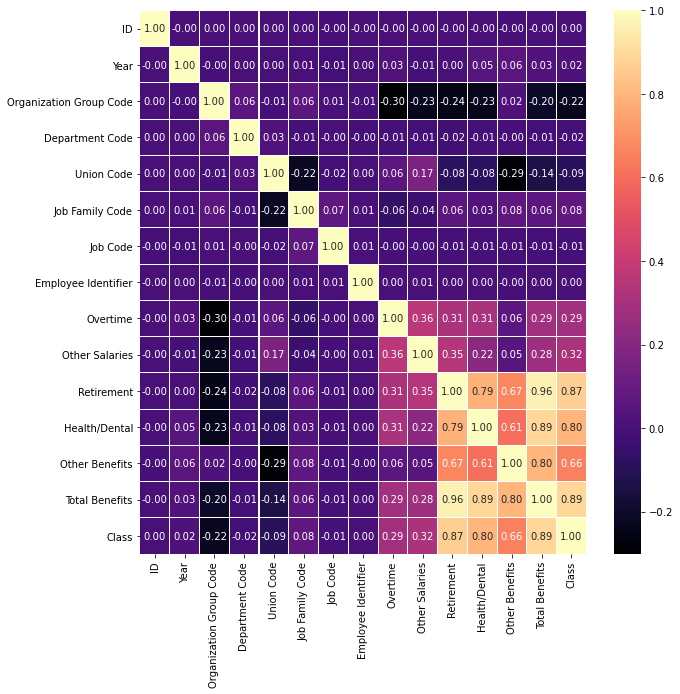

In [182]:
fig,ax = plt.subplots(figsize=(10, 10))   
sns.heatmap(train.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma") 

In [25]:
train.drop(columns=['ID','Year Type','Year','Organization Group',
                    'Department Code','Department','Union',
                    'Job Family','Job Code','Job',
                    'Employee Identifier'],axis=1,inplace=True)

In [184]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149087 entries, 0 to 149086
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Organization Group Code  149087 non-null  int64  
 1   Union Code               149087 non-null  int64  
 2   Job Family Code          149087 non-null  int64  
 3   Overtime                 149087 non-null  float64
 4   Other Salaries           149087 non-null  float64
 5   Retirement               149087 non-null  float64
 6   Health/Dental            149087 non-null  float64
 7   Other Benefits           149087 non-null  float64
 8   Total Benefits           149087 non-null  float64
 9   Class                    149087 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 11.4 MB


In [26]:
#Dropping the target column 'Class' from the train data & storing it into a new variable
y = train['Class']
train.drop('Class',axis=1,inplace=True)

In [27]:
x_train,x_val,y_train,y_val = train_test_split(train,y,test_size=0.3,random_state=42,stratify=y)

In [35]:
y_train.value_counts()

3    35567
2    34723
1    34070
Name: Class, dtype: int64

In [28]:
over = SMOTE(sampling_strategy={1:35000,2:35000},random_state=42)
under = RandomUnderSampler(sampling_strategy={3:35000})

In [29]:
model = RandomForestClassifier(criterion='entropy',
                              oob_score=True,
                              random_state=42,
                              n_jobs=-1)

In [30]:
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)

In [31]:
start_time = timeit.default_timer()
pipeline.fit(x_train,y_train)
print ('\n','Training Accuracy is: ',pipeline.score(x_train,y_train))
stop_time = timeit.default_timer()
print('\n','Total Training Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


start_time = timeit.default_timer()
y_pred_test = model.predict(x_val)
stop_time = timeit.default_timer()
print ('\n','Testing Accuracy is: ',metrics.accuracy_score(y_val,y_pred_test))
print('\n','Total Testing Time: {time} seconds.'.format(time=round(stop_time - start_time, 2)))


 Training Accuracy is:  0.9998466845534688

 Total Training Time: 26.24 seconds.

 Testing Accuracy is:  0.9825385114136875

 Total Testing Time: 0.43 seconds.


In [32]:
#Viewing the classification report
print (metrics.classification_report(y_val,y_pred_test))

precision    recall  f1-score   support

           1       0.99      0.99      0.99     14602
           2       0.98      0.97      0.97     14881
           3       0.99      0.99      0.99     15244

    accuracy                           0.98     44727
   macro avg       0.98      0.98      0.98     44727
weighted avg       0.98      0.98      0.98     44727



#### *We have reduced the number of features from 19 to 8 & thereafter the model build on this reduced set of features is giving comparable accuracy as the model built previously. However, the class-wise accuracy continues to be slightly imbalanced*
#### *Let us see how this model performs over the entire dataset through 10-fold Cross Validation*

In [34]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores=cross_val_score(model,train,y,scoring='accuracy',cv=cv,n_jobs=-1,verbose=1)
print('Average Score across 10-fold Cross-Validation over 3 iterations is: ',scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Average Score across 10-fold Cross-Validation over 3 iterations is:  0.9840585307956184
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 40.7min finished


#### *Thus the same RandomForestClassifier model which was able to achieve an overall accuracy of 98.6% with a much larger set of features, suffers a drop of only 0.2% when the number of features is considerably reduced. This is an average over a 10-fold cross-validation performed over the entire dataset, sans those unnecesaary features. Hence it can be concluded that those features were not exactly needed & we thus have a much simpler model at hand with comparable accuracy.*